# Imports and dataset loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.multioutput import MultiOutputRegressor
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import pandas as pd

layerArray       = [2, 4, 8, 16, 32]
gainArray        = []
lossArray        = []
gainDistribution = []
lossDistribution = []
strategyArray    = []
ampNumber        = 4

originalDataSet = pd.read_csv('dataset.txt', sep = ',',header = None)
binaryDataSet   = []

for line in originalDataSet.values:
    myList = [1 if i != 0 else 0 for i in line[:40]]
    myList.extend(line[40:])
    binaryDataSet.append(myList)

binaryDataSet = pd.DataFrame(binaryDataSet)
gainScaler    = MinMaxScaler(feature_range = (-1, 1))
lossScaler    = MinMaxScaler(feature_range = (-1, 1))

gainScalerAux = []
lossScalerAux = []

for i in range(0, ampNumber * 2, 2):
    gainScalerAux.extend(binaryDataSet.values[:, 40 + i])
    lossScalerAux.extend(binaryDataSet.values[:, 40 + i + 1])

gainScaler.fit(np.array(gainScalerAux).reshape(-1, 1))
lossScaler.fit(np.array(lossScalerAux).reshape(-1, 1))

def loadDataset(): 
    dataSet = binaryDataSet.values[:, :40]
    
    for i in range(0, ampNumber * 2, 2):
        gain    = np.array(binaryDataSet.values[:, 40 + i])
        gain    = gainScaler.transform(gain.reshape(-1, 1))
        dataSet = np.hstack((dataSet, gain))
        
        loss    = np.array(binaryDataSet.values[:, 40 + i + 1])
        loss    = lossScaler.transform(gain.reshape(-1, 1))
        dataSet = np.hstack((dataSet, loss))
            
    features, result = np.array(dataSet[:, :40]), np.array(dataSet[:, 40:])
    return features, result

def invertGainNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return gainScaler.inverse_transform(auxArray)[0][0]

def invertLossNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return lossScaler.inverse_transform(auxArray)[0][0]
    
def getGainError(value1, value2):
    return abs(invertGainNorm(value1) - invertGainNorm(value2))

def getLossError(value1, value2):
    return abs(invertLossNorm(value1) - invertLossNorm(value2))

features, result = loadDataset()

originalDataSet = pd.read_csv('dataset.txt', sep = ',',header = None)
binaryDataSet   = []

for line in originalDataSet.values:
    myList = [1 if i != 0 else 0 for i in line[:40]]
    myList.extend(line[40:])
    binaryDataSet.append(myList)

binaryDataSet = pd.DataFrame(binaryDataSet)
gainScaler    = MinMaxScaler(feature_range = (-1, 1))
lossScaler    = MinMaxScaler(feature_range = (-1, 1))

gainScalerAux = []
lossScalerAux = []

for i in range(0, ampNumber * 2, 2):
    gainScalerAux.extend(binaryDataSet.values[:, 40 + i])
    lossScalerAux.extend(binaryDataSet.values[:, 40 + i + 1])

gainScaler.fit(np.array(gainScalerAux).reshape(-1, 1))
lossScaler.fit(np.array(lossScalerAux).reshape(-1, 1))

def loadDataset(): 
    dataSet = binaryDataSet.values[:, :40]
    
    for i in range(0, ampNumber * 2, 2):
        gain    = np.array(binaryDataSet.values[:, 40 + i])
        gain    = gainScaler.transform(gain.reshape(-1, 1))
        dataSet = np.hstack((dataSet, gain))
        
        loss    = np.array(binaryDataSet.values[:, 40 + i + 1])
        loss    = lossScaler.transform(loss.reshape(-1, 1))
        dataSet = np.hstack((dataSet, loss))
    
    features, result = np.array(dataSet[:, :40]), np.array(dataSet[:, 40:])
    return features, result

def invertGainNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return gainScaler.inverse_transform(auxArray)[0][0]

def invertLossNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return lossScaler.inverse_transform(auxArray)[0][0]
    
def getGainError(value1, value2):
    return abs(invertGainNorm(value1) - invertGainNorm(value2))

def getLossError(value1, value2):
    return abs(invertLossNorm(value1) - invertLossNorm(value2))

features, result = loadDataset()

Using TensorFlow backend.


# Cross validation function

In [2]:
def crossValidate(regressor, layers, features, result, folds = 5):
    foldSize   = math.ceil(features.shape[0] / folds)
    gainErrors = []
    lossErrors = []
    
    for i in range(folds): 
        sliceBegin = i * foldSize
        sliceEnd   = (i + 1) * foldSize
        
        X_train = np.delete(features, np.s_[sliceBegin: sliceEnd], 0)
        y_train = np.delete(result, np.s_[sliceBegin: sliceEnd], 0)
        
        regressor.fit(X_train, y_train)         
        
        X_test = features[sliceBegin: sliceEnd]
        y_test = result[sliceBegin: sliceEnd]
        
        gainError = 0
        lossError = 0
        
        prediction = regressor.predict(X_test)
        
        for predicted, expected in zip(prediction, y_test):
            for i in range(0, ampNumber * 2, 2):
                gainError += getGainError(predicted[i], expected[i]) 
                lossError += getLossError(predicted[i + 1], expected[i + 1])
                 
        gainErrors.append((gainError / ampNumber) / foldSize)
        lossErrors.append((lossError / ampNumber) / foldSize) # average loss error by amp

    return np.array(gainErrors), np.array(lossErrors)

In [3]:
def trainModel(strategy, layers):    
    features, result       = loadDataset()
    gainErrors, lossErrors = crossValidate(strategy, layers, features, result)

    print(gainErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(gainErrors), gainErrors.std() * 2))
    print(lossErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(lossErrors), lossErrors.std() * 2))
    print()
    
    gainArray.append(np.mean(gainErrors))
    lossArray.append(np.mean(lossErrors))

def setMLP(layers):
    if layers == 2:
        return MLPRegressor(hidden_layer_sizes = (8, 8), activation = 'identity', learning_rate = 'constant', alpha = 0.001, random_state = 0)
    
    if layers == 4:
        return MLPRegressor(hidden_layer_sizes = (8, 16, 8, 4), activation = 'identity', learning_rate = 'constant', alpha = 0.001, random_state = 0)
    
    if layers == 8:
        return MLPRegressor(hidden_layer_sizes = (8, 16, 32, 64, 32, 16, 8, 4), activation = 'identity', learning_rate = 'constant', alpha = 0.001, random_state = 0)
    
    if layers == 16:
        return MLPRegressor(hidden_layer_sizes = (8, 16, 16, 32, 32, 64, 64, 64, 64, 32, 32, 16, 16, 8, 8, 4), activation = 'identity', learning_rate = 'constant', alpha = 0.001, random_state = 0)
    
    if layers == 32:
        return MLPRegressor(hidden_layer_sizes = (8, 8, 16, 16, 16, 16, 32, 32, 32, 32, 64, 64, 64, 64, 128, 128, 128, 128, 64, 64, 64, 64, 32, 32, 32, 32, 16, 16, 16, 16, 8, 4), activation = 'identity', learning_rate = 'constant', alpha = 0.001, random_state = 0)


# Plotting functions

In [4]:
def plotGainError():
    fig7, axis = plt.subplots(figsize = (10, 5))

    axis.plot(layerArray, gainArray, 'sb-')
    axis.set_title("Gain error")
    axis.set_ylabel("Absolute error", fontsize = 14)
    axis.set_xlabel("Number of layers", fontsize = 14)
    #axis.legend(strategyArray)

    plt.show()

In [5]:
def plotLossError():
    fig7, axis = plt.subplots(figsize = (10, 5))

    axis.plot(layerArray, lossArray, 'or--')
    axis.set_title("Loss error")
    axis.set_ylabel("Absolute error", fontsize = 14)
    axis.set_xlabel("Number of layers", fontsize = 14)
    #axis.legend(strategyArray)

    plt.show()

In [6]:
def plotGainDistribution(regressor, layers):
    features, result = loadDataset()

    predicted = regressor.predict(features)
    fig, axis = plt.subplots(figsize = (10, 5))
    vFunc     = np.vectorize(invertGainNorm)

    axis.scatter(vFunc(result[:, 0]), vFunc(predicted[:, 0]))
    axis.set_title("Gain Distribution - {} layers".format(layers))
    axis.set_xlabel("Expected")
    axis.set_ylabel("Predicted")

    plt.show()

In [7]:
def plotLossDistribution(regressor, layers):
    features, result = loadDataset()

    predicted = regressor.predict(features)
    fig, axis = plt.subplots(figsize = (10, 5))
    vFunc     = np.vectorize(invertLossNorm)
    
    axis.scatter(vFunc(result[:, 1]), vFunc(predicted[:, 1]), c = "m")
    axis.set_title("Loss Distribution - {} layers".format(layers))
    axis.set_xlabel("Expected")
    axis.set_ylabel("Predicted")

    plt.show()

# Putting all together

[2.47339746 2.17259555 2.20246485 1.75457343 2.34590391] => 2.19 (+/- 0.49)
[2.46854362 2.19037686 2.32559888 2.32377712 2.07370953] => 2.28 (+/- 0.27)



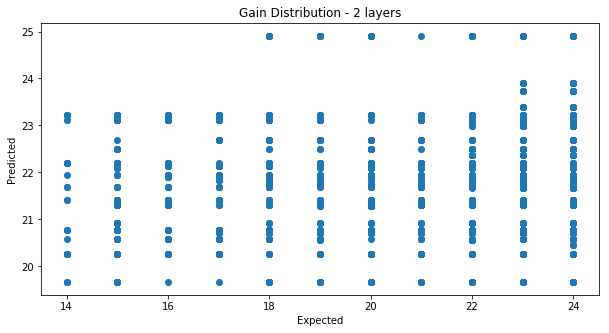

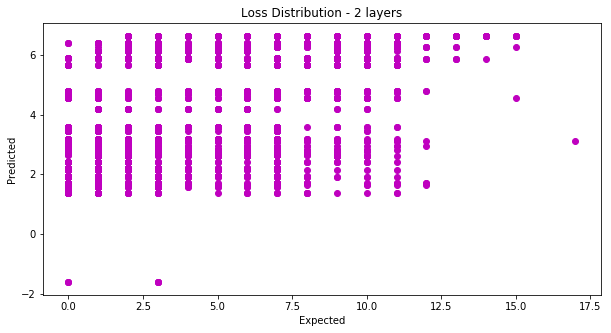

            0
0    0.444765
1    0.323035
2    0.244887
3    0.193307
4    0.161238
..        ...
142  0.069483
143  0.069307
144  0.069329
145  0.069256
146  0.069181

[147 rows x 1 columns]


In [8]:
regressor = setMLP(2)
trainModel(regressor, 2)
plotGainDistribution(regressor, 2)
plotLossDistribution(regressor, 2)

test = pd.DataFrame(regressor.loss_curve_)
print(test)

[2.32218913 2.12821038 2.11178321 1.90943895 2.25058297] => 2.14 (+/- 0.28)
[3.11552644 2.32741495 2.25389132 2.59753094 2.24156188] => 2.51 (+/- 0.66)



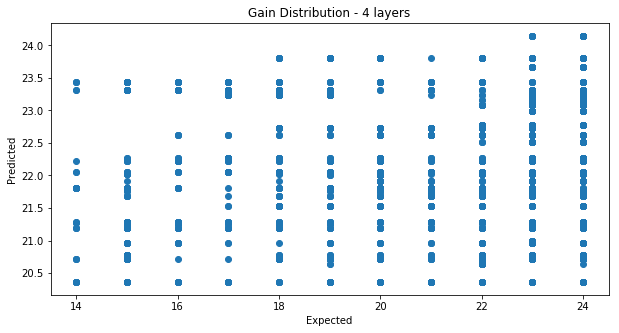

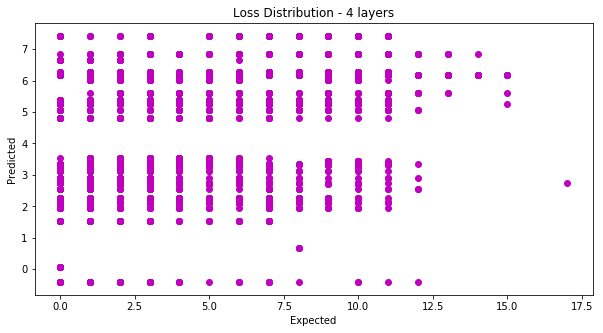

In [9]:
regressor = setMLP(4)
trainModel(regressor, 4)
plotGainDistribution(regressor, 4)
plotLossDistribution(regressor, 4)

[2.47203611 1.94760662 2.04735009 1.82392692 2.05950706] => 2.07 (+/- 0.44)
[2.81992107 2.33359942 2.20526596 2.19874006 1.94467569] => 2.30 (+/- 0.58)



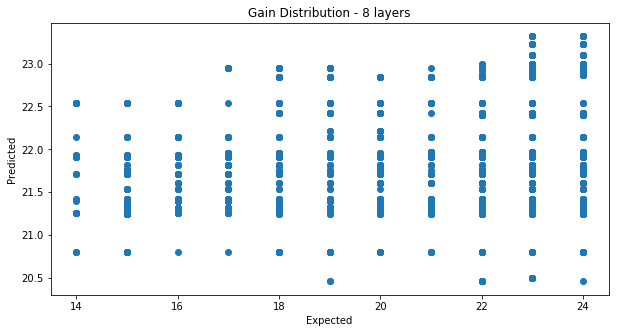

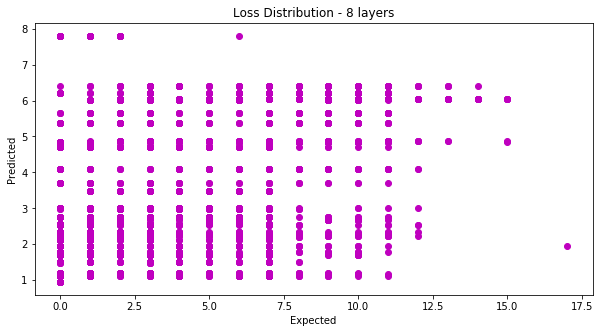

In [10]:
regressor = setMLP(8)
trainModel(regressor, 8)
plotGainDistribution(regressor, 8)
plotLossDistribution(regressor, 8)

[2.28954655 2.07764061 2.03485959 1.751455   2.33197155] => 2.10 (+/- 0.42)
[2.61529071 2.13779952 2.76231194 2.47902475 2.42953298] => 2.48 (+/- 0.42)



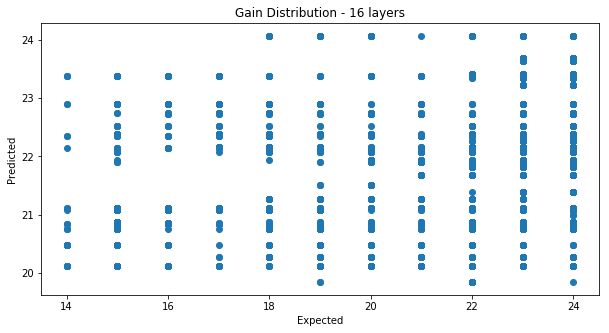

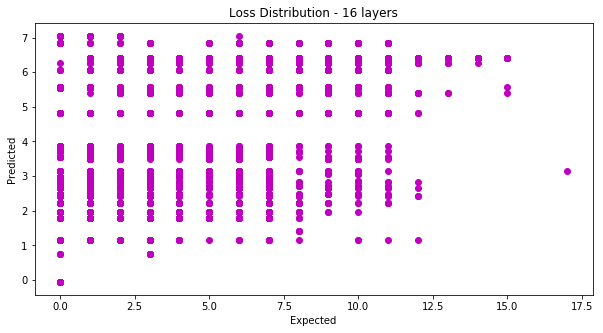

In [11]:
regressor = setMLP(16)
trainModel(regressor, 16)
plotGainDistribution(regressor, 16)
plotLossDistribution(regressor, 16)

[2.23045059 1.99640583 1.91676074 1.803643   2.14906365] => 2.02 (+/- 0.31)
[2.28469731 2.2486575  2.28439136 2.32488316 2.14772095] => 2.26 (+/- 0.12)



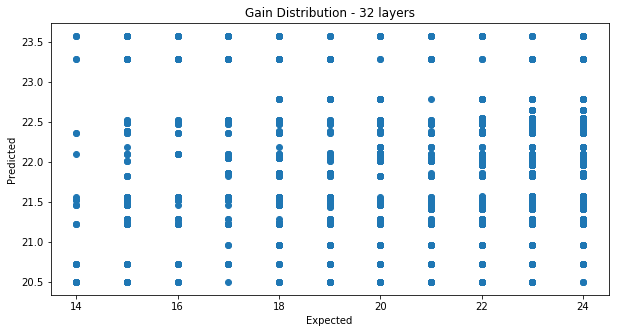

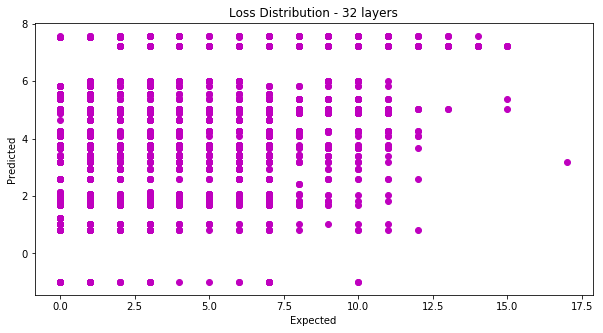

In [12]:
regressor = setMLP(32)
trainModel(regressor, 32)
plotGainDistribution(regressor, 32)
plotLossDistribution(regressor, 32)

# Plotting graphs

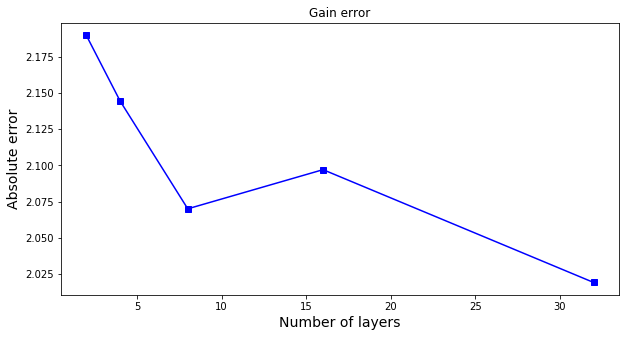

In [13]:
plotGainError()

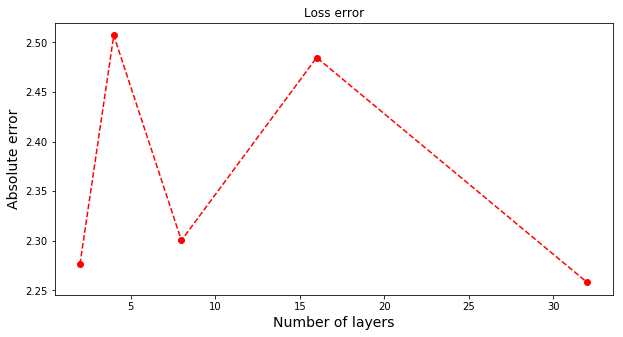

In [14]:
plotLossError()